In [1]:
from math import dist
from tqdm import tqdm
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import copy

## Visualization of data points

101 10 200


<AxesSubplot:xlabel='x', ylabel='y'>

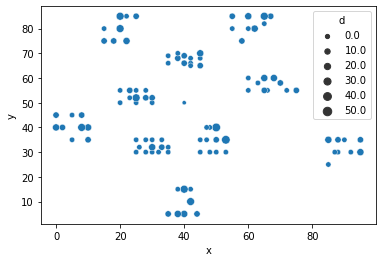

In [2]:
with open('data/vrp_101_10_1', 'r', encoding = 'utf-8') as f:
   n_locations, n_vehicles, cap = [int(x) for x in f.readline().split()]
   data = []
   for i in range(n_locations):
       data.append([float(x) for x in f.readline().split()])

data = np.array(data)
print(n_locations, n_vehicles, cap)
dataT = data.T
a = pd.DataFrame({'x':dataT[1], 'y':dataT[2] , 'd':dataT[0]})
sns.scatterplot(data=a, x='x', y='y', size='d', palette="deep")

## Split data points into clusters

In [3]:
def split_data_clusters(data, n_clusters):

    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(data[:,1:3])
    y_kmeans = kmeans.predict(data[:,1:3])
    data = np.column_stack((data, y_kmeans))

    plt.scatter(data[:, 1], data[:, 2], c=data[:, 3], s=10, cmap='viridis')
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=50, alpha=0.5);

    center = data[0]
    data = np.delete(data, 0, axis=0)
    data_sep = [np.row_stack((center, data[data[:,3]==k])) for k in np.unique(data[:,3])]
    return data_sep

## Creating a graph

In [4]:
class Graph:
    def __init__(self, x, y) -> None:
        self.n = n = len(x)
        self.x = np.array(x, dtype=float)
        self.y = np.array(y, dtype=float)
        self.edges = np.zeros(shape=(n,n), dtype=float)

        for i in range(self.n):
            for j in range(self.n):
                self.edges[i,j] = dist([x[i], y[i]], [x[j], y[j]])

        xf = np.average(self.edges)
        for i in range(self.n):
            self.edges[i,i] = xf

## Make a set of plots for visualization before and after optimization

In [5]:
def make_plots(vehicle_tours):
  fig, ax =  plt.subplots(1, 1, figsize=(10, 10))
  ax.set_ylabel('Y')
  ax.set_xlabel('X')
  # third plot, for tour after optimization
  for tour, graph in vehicle_tours:
    plot_x = []
    plot_y = []
    for i in tour:
        plot_x.append(graph.x[i])
        plot_y.append(graph.y[i])
    ax.plot(plot_x, plot_y, marker='o', linestyle='dashed')

## Defining the objective funtion

In [6]:
def objective(tour, graph):
    fitn = 0
    n = len(tour)
    for i in range(n-1):
        fitn += graph.edges[tour[i], tour[i+1]]
    return fitn

## Creating the colony

In [7]:
class Ant:
    def __init__(self) -> None:
        self.tour = []
        self.cost = np.inf

    def __repr__(self) -> str:
        return f'Ant(tour={self.tour}, o={self.cost})'

    def __lt__(self, other):
        return self.cost < other.cost

class Colony:
    def __init__(self, graph, n_ants, tau, eta, alpha, beta) -> None:
        self.n_vertex = n = graph.n
        self.n_ants = n_ants
        self.ants = [Ant() for i in range(n_ants)]

        for i in range(n_ants):
            self.ants[i].tour.append(0)
            for j in range(2, n + 1):
                last = self.ants[i].tour[-1]
                probs = (tau[last] ** alpha) * (eta[last] ** beta)
                probs[probs <= 0.00001] = 0.00001
                probs[self.ants[i].tour] = 0
                probs = probs / np.sum(probs)
                self.ants[i].tour.append(np.random.choice(n, p=probs))
            self.ants[i].tour.append(0)

        for i in range(n_ants):
            self.ants[i].cost = objective(self.ants[i].tour, graph)

        self.queen = copy.deepcopy(min(self.ants))

## Function to update pheromones

In [8]:
def update_pheromones(colony, tau):
    n_ants = colony.n_ants
    n_vertex = colony.n_vertex

    for i in range(n_ants):
        for j in range(n_vertex - 1):
            cur, nxt = colony.ants[i].tour[j:j+2]
            tau[cur][nxt] += 1/colony.ants[i].cost
            tau[nxt][cur] += 1/colony.ants[i].cost

## Function to implement ACO

In [9]:
def run_ACO(n_ants, max_iter, graph, tau, eta, rho, alpha, beta):

    best_ant = Ant()
    costs = []
    # taus = []

    for t in tqdm(range(max_iter)):
        # if t % 10 == 0:
        #     taus.append(np.max(tau, axis=1))
        colony = Colony(graph, n_ants, tau, eta, alpha, beta)
        
        if colony.queen.cost < best_ant.cost:
            best_ant.tour = colony.queen.tour.copy()
            best_ant.cost = colony.queen.cost

        update_pheromones(colony, tau)
        tau = (1-rho) * tau

        costs.append(best_ant.cost)
    # sns.heatmap(taus)
    return best_ant, costs

In [10]:
def helper_function(data):
    dataT = data.T
    graph = Graph(dataT[1], dataT[2])
    graph = Graph(dataT[1], dataT[2])

    # creating eta matrix
    with np.errstate(divide='ignore',invalid='ignore'):
        eta = 1/graph.edges
    eta[eta == np.inf] = 0

    # creating tau matrix
    tau = np.full(eta.shape, 10/np.sum(graph.edges))
    return graph, eta, tau

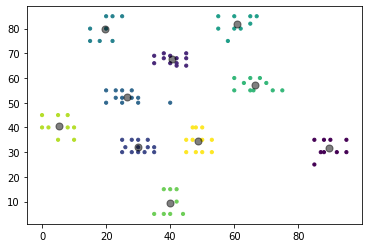

In [11]:
data_sep = split_data_clusters(data, n_clusters=10)

In [12]:
vehicle_tours = []
tot_cost = 0

for data in data_sep:
    graph, eta, tau = helper_function(data)
    best_ant, costs = run_ACO(n_ants = graph.n, 
                            max_iter = 100, 
                            graph = graph, 
                            tau = tau, 
                            eta = eta, 
                            rho = 0.25, 
                            alpha = 1,
                            beta = 1)
    tot_cost += best_ant.cost
    vehicle_tours.append((best_ant.tour, graph));

100%|██████████| 100/100 [00:00<00:00, 108.23it/s]


831.1256798858258

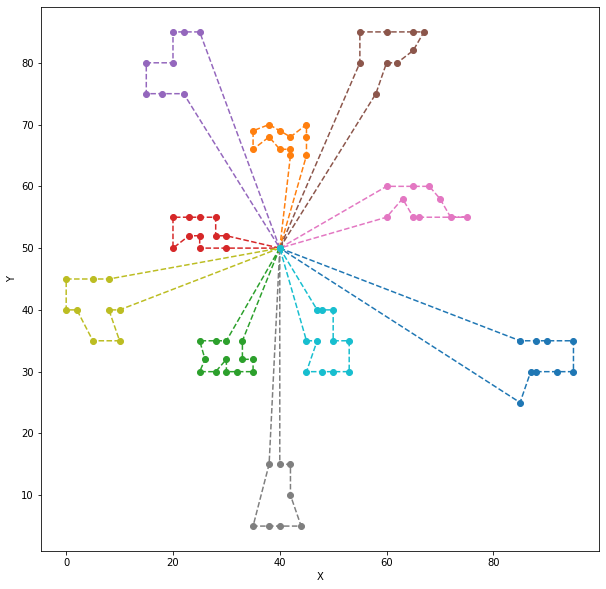

In [13]:
make_plots(vehicle_tours)
tot_cost